In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_loader import calculate_rsi, get_data, get_fast_data
from backtest import backtest, fast_backtest, plot_backtest, fitness_sharpe_ratio
from grammar import grammar
from grammatical_evolution import map_genotype_to_fenotype
from selections import roulette_selection, tournament_selection
from crossovers import one_point_crossover
from mutations import random_mutation

In [3]:
def evolution(population_size, chromosome_size, crossover_probability, mutation_probability, number_of_iterations, number_of_offspring, data, grammar, initial_cash, max_depth, selection, fitness_function=fast_backtest, crossover=None, mutation=None, k=5):
    best_objective_value = -np.inf
    best_chromosome = None
    best_rule = None
    history = []
    current_population = np.random.randint(256, size=(population_size, chromosome_size))
    objective_values = np.zeros(population_size)
    for _ in range(number_of_iterations):
        # evaluating the objective function on the current population
        objective_values = np.zeros(population_size)
        for i, genotype in enumerate(current_population):
            rule = map_genotype_to_fenotype(genotype, grammar, max_depth)
            if rule is None:
                objective_values[i] = -100.0 * initial_cash
            else:
                try:
                    score = fitness_function(rule, data, initial_cash)
                    objective_values[i] = score
                except:
                    objective_values[i] = -100.0 * initial_cash
        
        # update best chromosome
        current_best = np.max(objective_values)
        history.append(current_best)
        if current_best > best_objective_value:
            best_idx = np.argmax(objective_values)
            best_chromosome = current_population[best_idx].copy()
            best_objective_value = current_best
            best_rule = map_genotype_to_fenotype(best_chromosome, grammar, max_depth)
            print(f"Znaleziono nowy najlepszy wynik: {current_best}, rule = {best_rule}")
        
        parents = selection(objective_values, current_population, number_of_offspring, k=k)

        # crossover
        offspring = np.zeros((number_of_offspring, chromosome_size), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            p1 = parents[2*i].copy()
            p2 = parents[2*i+1].copy()

            if crossover and np.random.random() < crossover_probability:
                offspring[2*i, :], offspring[2*i+1, :] = crossover(p1, p2)
            else:
                offspring[2*i, :], offspring[2*i+1, :] = p1, p2
        if np.mod(number_of_offspring, 2) == 1:
            offspring[-1, :] = current_population[0, :]

        # mutation
        if mutation:
            for i in range(number_of_offspring):
                if np.random.random() < mutation_probability:
                    offspring[i, :] = mutation(offspring[i, :])
        
        current_population = offspring

    
    return best_chromosome, best_objective_value, best_rule, history

In [4]:
print(evolution(1000, 50, 0.8, 0.15, 100, 1000, get_fast_data('MSFT'), grammar, 1000, 10, selection=roulette_selection, crossover=one_point_crossover, mutation=random_mutation))

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2245.2778561514265, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>=', 'right': 'SMA10'}, 'logic_op': 'AND', 'right': {'left': {'left': {'left': {'left': 'Close', 'op': '==', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': 'RSI', 'op': '>', 'right': 'RSI'}}, 'logic_op': 'AND', 'right': {'left': 40, 'op': '<', 'right': 'RSI'}}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '>=', 'right': 'RSI'}}}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2460.7358562066265, rule = {'type': 'if', 'condition': {'left': {'left': {'left': 'RSI', 'op': '<=', 'right': 'RSI'}, 'logic_op': 'AND', 'right': {'left': 70, 'op': '<=', 'right': 'RSI'}}, 'logic_op': 'OR', 'right': {'left': 80, 'op': '==', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
(array([250, 224, 211,  18,  28, 228,  53, 150, 124,  16,  

In [5]:
def compare_profit(ticker, population=500, chromosome_size=50, iterations=100, initial_cash=1000, max_depth=6, split_ratio=0.8, selection=roulette_selection, fitness_function=fast_backtest, crossover=one_point_crossover, mutation=random_mutation):
    print(f"Running experiment on ticker: {ticker}\n")
    data_full = get_fast_data(ticker, start="2018-01-01", end="2025-01-01")

    n_total = len(data_full['Close'])
    split_idx = int(n_total * split_ratio)

    data_train = {key: val[:split_idx] for key, val in data_full.items()}
    data_test =  {key: val[split_idx:] for key, val in data_full.items()}

    print(f"Running evolution")

    _, _, best_rule, _ = evolution(population, chromosome_size, 0.8, 0.15, iterations, population, data_train, grammar, initial_cash, max_depth, selection=selection, fitness_function=fitness_function, crossover=crossover, mutation=mutation)

    print(f"Best rule found:\n{best_rule}\n")

    return_train = fast_backtest(best_rule, data_train, initial_cash)
    return_test = fast_backtest(best_rule, data_test, initial_cash)

    train_prices = data_train['Close']
    bh_return_train = ((initial_cash / train_prices[0]) * train_prices[-1]) - initial_cash
    
    test_prices = data_test['Close']
    bh_return_test = ((initial_cash / test_prices[0]) * test_prices[-1]) - initial_cash

    print(f"Algorytm na danych treningowych zarobił: {return_train}")
    print(f"Buy and hold na danych treningowych zarobiło: {bh_return_train}")
    print(f"Algorytm na danych testowych zarobił: {return_test}")
    print(f"Buy and hold na danych testowych zarobiło: {bh_return_test}")

    return best_rule


In [6]:
def compare_profit_with_plot(ticker, population=500, chromosome_size=50, iterations=100, initial_cash=1000, max_depth=6, split_ratio=0.8, selection=roulette_selection, fitness_function=fast_backtest, crossover=one_point_crossover, mutation=random_mutation):
    print(f"Running experiment on ticker: {ticker}\n")
    data_full = get_fast_data(ticker, start="2018-01-01", end="2025-01-01")

    n_total = len(data_full['Close'])
    split_idx = int(n_total * split_ratio)

    data_train = {key: val[:split_idx] for key, val in data_full.items()}
    data_test =  {key: val[split_idx:] for key, val in data_full.items()}

    print(f"Running evolution")

    _, _, best_rule, _ = evolution(population, chromosome_size, 0.8, 0.15, iterations, population, data_train, grammar, initial_cash, max_depth, selection=selection, fitness_function=fitness_function, crossover=crossover, mutation=mutation)

    print(f"Best rule found:\n{best_rule}\n")

    return_train = fast_backtest(best_rule, data_train, initial_cash)
    return_test = fast_backtest(best_rule, data_test, initial_cash)

    train_prices = data_train['Close']
    bh_return_train = ((initial_cash / train_prices[0]) * train_prices[-1]) - initial_cash
    
    test_prices = data_test['Close']
    bh_return_test = ((initial_cash / test_prices[0]) * test_prices[-1]) - initial_cash

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    train_curve = plot_backtest(best_rule, data_train, initial_cash)
    test_curve = plot_backtest(best_rule, data_test, initial_cash)
    bh_train_curve = (train_prices / train_prices[0]) * initial_cash
    bh_test_curve = (test_prices / test_prices[0]) * initial_cash

    ax1.plot(bh_train_curve, label='Buy and Hold', color='gray', linestyle='--')
    ax1.plot(train_curve, label='Evolution strategy', color='blue')
    ax1.set_title(f'{ticker} - TRENING')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(bh_test_curve, label='Buy and Hold', color='gray', linestyle='--')
    ax2.plot(test_curve, label='Evolution strategy', color='orange')
    ax2.set_title(f'{ticker} - TEST')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Algorytm na danych treningowych zarobił: {return_train}")
    print(f"Buy and hold na danych treningowych zarobiło: {bh_return_train}")
    print(f"Algorytm na danych testowych zarobił: {return_test}")
    print(f"Buy and hold na danych testowych zarobiło: {bh_return_test}")

    return best_rule


Running experiment on ticker: TSLA



[*********************100%***********************]  1 of 1 completed


Running evolution
Znaleziono nowy najlepszy wynik: 14759.83456597391, rule = {'type': 'if', 'condition': {'left': 60, 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': {'left': {'left': 30, 'op': '>', 'right': 20}, 'logic_op': 'AND', 'right': {'left': {'left': 70, 'op': '>=', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': 'SMA50', 'op': '<=', 'right': 'RSI'}}}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '<=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 21711.800918751786, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<=', 'right': 'SMA10'}, 'logic_op': 'OR', 'right': {'left': 'RSI', 'op': '==', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Best rule found:
{'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<=

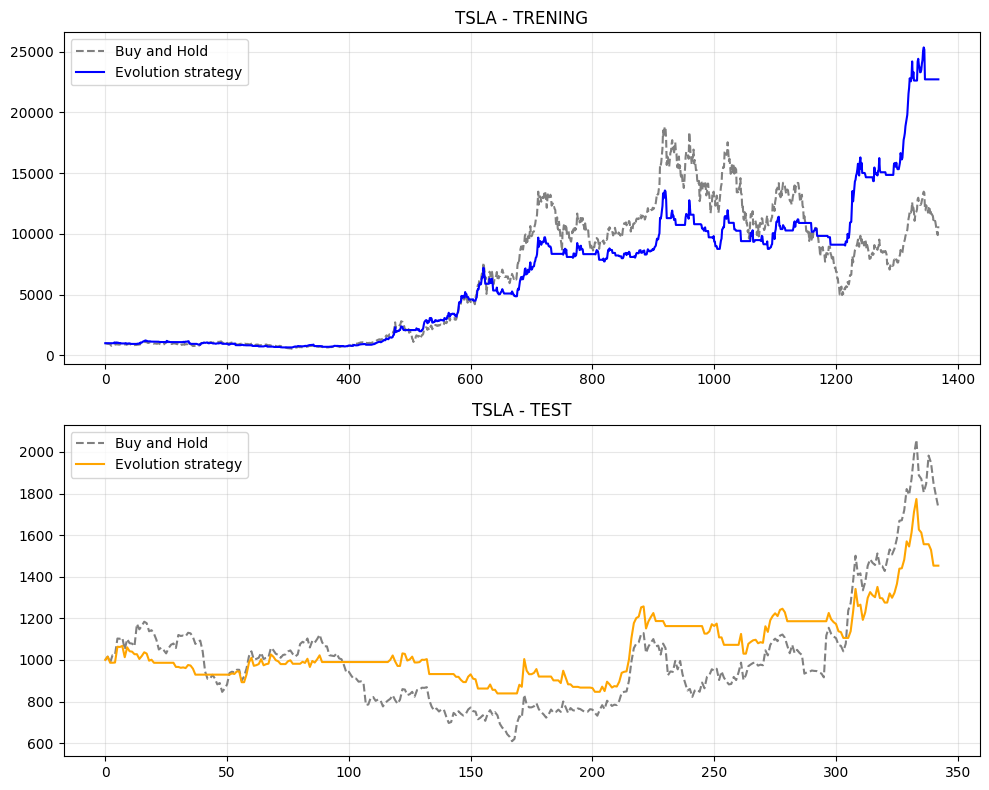

Algorytm na danych treningowych zarobił: 21711.800918751786
Buy and hold na danych treningowych zarobiło: 9621.19208384042
Algorytm na danych testowych zarobił: 453.1791417051006
Buy and hold na danych testowych zarobiło: 731.8066474113259


{'type': 'if',
 'condition': {'left': {'left': 'Close', 'op': '<=', 'right': 'SMA10'},
  'logic_op': 'OR',
  'right': {'left': 'RSI', 'op': '==', 'right': 'SMA10'}},
 'then': {'type': 'action', 'value': 'SELL'},
 'else': {'type': 'action', 'value': 'BUY'}}

In [7]:
compare_profit_with_plot('TSLA', max_depth=50, selection=tournament_selection)

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2303.923218973493, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 2541.215966490524, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 70}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2866.0439764227176, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 70}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}


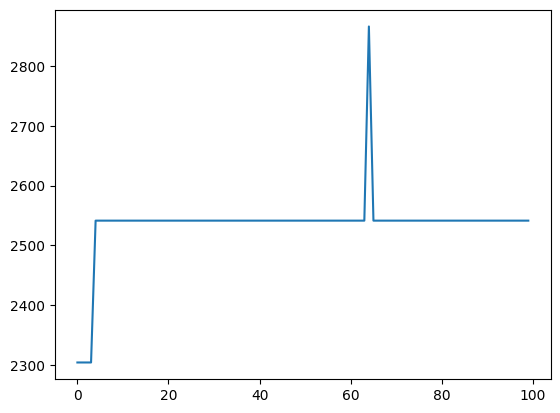

In [8]:
_, _, _, history = evolution(500, 50, 0.5, 0.5, 100, 500, get_fast_data('GOOGL'), grammar, 1000, 5, tournament_selection, fast_backtest, one_point_crossover, random_mutation, k=2)
plt.plot(history)

In [9]:
def compare_profits(tickers, population=500, chromosome_size=50, iterations=100, initial_cash=1000, crossover_probability=0.8, mutation_probability=0.15, max_depth=6, split_ratio=0.8, selection=roulette_selection, fitness_function=fast_backtest, crossover=one_point_crossover, mutation=random_mutation, seed=42):
    res = []
    print(f"Running experiment on ticker: {tickers}\n")

    np.random.seed(seed)

    for ticker in tickers:
        data_full = get_fast_data(ticker, start="2018-01-01", end="2025-01-01")

        n_total = len(data_full['Close'])
        split_idx = int(n_total * split_ratio)

        data_train = {key: val[:split_idx] for key, val in data_full.items()}
        data_test =  {key: val[split_idx:] for key, val in data_full.items()}

        _, _, best_rule, _ = evolution(population, chromosome_size, crossover_probability, mutation_probability, iterations, population, data_train, grammar, initial_cash, max_depth, selection=selection, fitness_function=fitness_function, crossover=crossover, mutation=mutation)

        return_train = fast_backtest(best_rule, data_train, initial_cash)
        return_test = fast_backtest(best_rule, data_test, initial_cash)

        train_prices = data_train['Close']
        bh_return_train = ((initial_cash / train_prices[0]) * train_prices[-1]) - initial_cash
        
        test_prices = data_test['Close']
        bh_return_test = ((initial_cash / test_prices[0]) * test_prices[-1]) - initial_cash

        res.append({
                'ticker': ticker,
                'train': return_train,
                'bh_train': bh_return_train,
                'test': return_test,
                'bh_test': bh_return_test
            })
        
    return pd.DataFrame(res)

In [10]:
def plot_portfolio_comparison(df_results):
    tickers = df_results['ticker']
    x = np.arange(len(tickers))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    rects1 = ax1.bar(x - width/2, df_results['train'], width, label='Strategia ewolucyjna', color='forestgreen')
    rects2 = ax1.bar(x + width/2, df_results['bh_train'], width, label='Buy & Hold', color='lightgray', edgecolor='black')

    ax1.set_title('Wyniki na zbiorze treningowym', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Zysk (USD)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(tickers)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    rects3 = ax2.bar(x - width/2, df_results['test'], width, label='Strategia ewolucyjna', color='royalblue')
    rects4 = ax2.bar(x + width/2, df_results['bh_test'], width, label='Buy & Hold', color='lightgray', edgecolor='black')

    ax2.set_title('Wyniki na Zbiorze TESTOWYM (Weryfikacja)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Zysk (USD)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(tickers)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    ax1.axhline(0, color='black', linewidth=0.8)
    ax2.axhline(0, color='black', linewidth=0.8)

    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)
    autolabel(rects3, ax2)
    autolabel(rects4, ax2)

    plt.tight_layout()
    plt.show()

In [ ]:
tickers = [
    # Hossa
    'AVGO',  # Broadcom
    'COST',  # Costco
    'META',  # Meta
    'AAPL',  # Apple

    # Bessa 
    'VFC',   # VF Corp (Vans, North Face)
    'DG',    # Dollar General
    'PSKY',  # Paramount
    'MRNA',  # Moderna 
    'PFE',   # Pfizer
    

    # High volatility
    'SMCI',  # Super Micro
    'SHOP',  # Shopify
    'VZ',    # Verizon
    'T',     # AT&T
    'KHC',   # Kraft Heinz

    # Stable
    'F',      # Ford
    'RIVN'   # Rivian
]

Running experiment on ticker: ['AVGO', 'COST', 'META', 'AAPL', 'VFC', 'DG', 'PSKY', 'MRNA', 'PFE', 'SMCI', 'SHOP', 'VZ', 'T', 'KHC', 'F', 'RIVN']



[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 3581.260482924199, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': {'left': 40, 'op': '<=', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': 30, 'op': '<', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 3901.6996488854584, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2155.312790238569, rule = {'type': 'if', 'condition': {'left': 30, 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2209.797284722895, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 20}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1857.0021158248483, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 100}, 'then': {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>', 'right': 70}, 'logic_op': 'AND', 'right': {'left': 100, 'op': '<', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 2005.0789201678167, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 100}, 'then': {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>', 'right': 70}, 'logic_op': 'AND', 'right': {'left': 100, 'op': '<', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 3409.45182161299, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 22.883090054801187, rule = {'type': 'if', 'condition': {'left': 90, 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1274.8071181653022, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA50', 'op': '<=', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': {'left': 'RSI', 'op': '<', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'SMA50'}}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'HOLD'}}}
Znaleziono nowy najlepszy wynik: 1276.7098098482757, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 1612

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 5498.136534827548, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 4756.350412656109, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 9145.882327341571, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 10389.5431318163, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA50', 'op': '<=', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1199.6698979219982, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 1340.892226758076, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>=', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '==', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 13273.446447010865, rule = {'type': 'if', 'condition': {'left': 50, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 14219.277377688575, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '==', 'right': 'SMA10'}, 'logic_op': 'AND', 'right': {'left': 20, 'op': '==', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 20}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 9491.635936194332, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<', 'right': 50}, 'logic_op': 'OR', 'right': {'left': 'RSI', 'op': '>', 'right': 'SMA50'}}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'HOLD'}}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 11047.805322977854, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': {'left': 'SMA50', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '<', 'right': 'Close'}}, 't

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 647.5555059699484, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 917.3181422971613, rule = {'type': 'if', 'condition': {'left': {'left': {'left': 'SMA10', 'op': '<', 'right': 'RSI'}, 'logic_op': 'AND', 'right': {'left': 'SMA10', 'op': '<', 'right': 100}}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 1013.7362462062272, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'logic_op': 'AND', 'right': {'left': 60, 'op': '>=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 123.11208665132222, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 221.4102744178581, rule = {'type': 'if', 'condition': {'left': 80, 'op': '==', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 225.82189272701203, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 427.93049185338396, rule = {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 532.1536752311006, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': {'left': 'SMA10', 'op': '>', 'right': 'RSI'}, 'logic_op': 'AND', 'right': {'left': 20, 'op': '>', 'right': 'Close'}}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 563.0942975608812, rule = {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 30}, 'then': {'type': 'if', 'condition': {'left': {'left': 20, 'op': '<=', 'right': 40}, 'logic_op': 'AND', 'right': {'left': 30, 'op': '>=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'act

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1978.5981365446892, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 40}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 2198.884638934962, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 40}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 2588.38303231229

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 110.92952258626337, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '==', 'right': 100}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 60, 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<', 'right': 'RSI'}, 'logic_op': 'AND', 'right': {'left': 'SMA50', 'op': '<=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}}}
Znaleziono nowy najlepszy wynik: 174.98668018866852, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 60, 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type

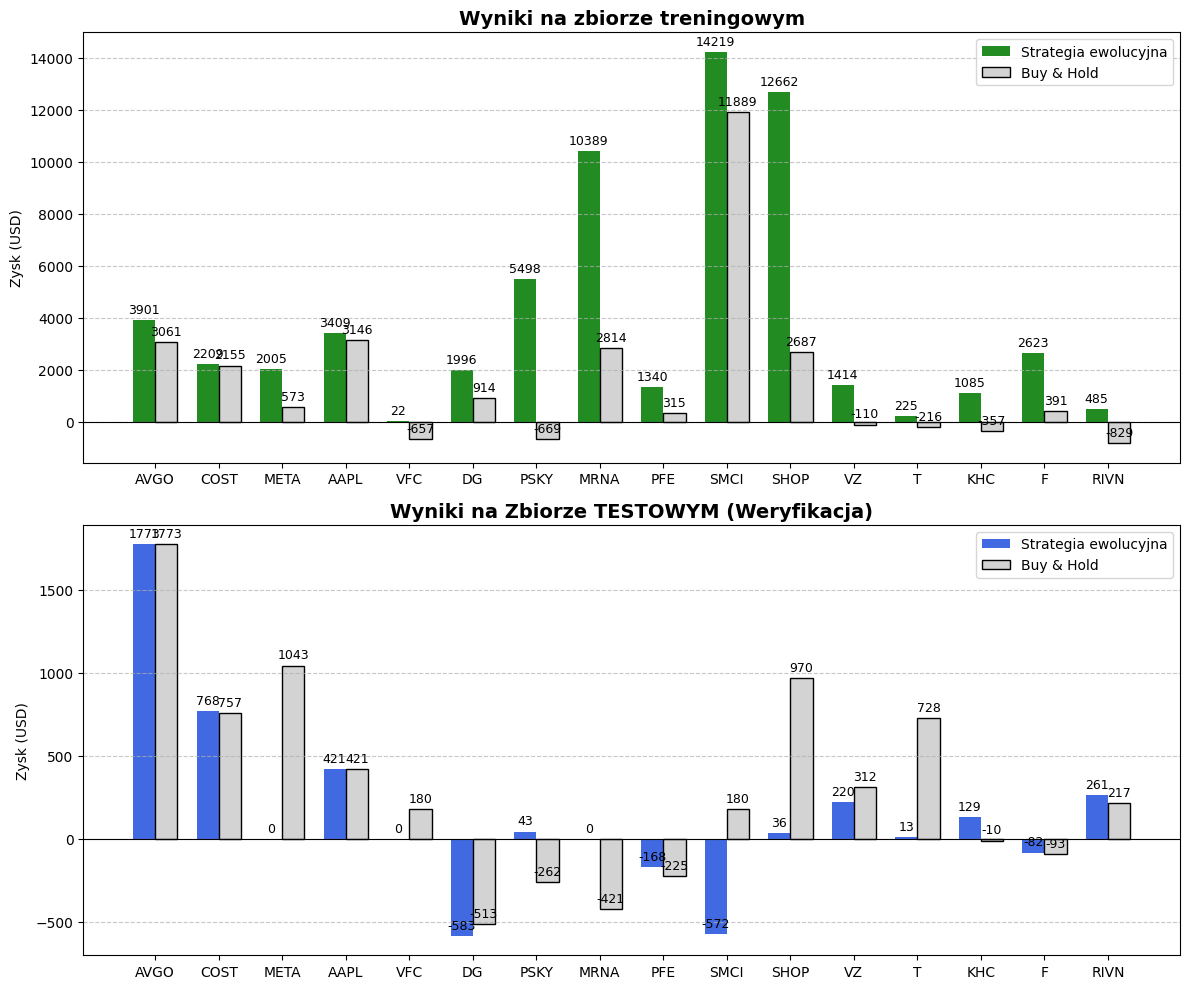

In [12]:
plot_portfolio_comparison(compare_profits(tickers, population=800, selection=tournament_selection, fitness_function=fast_backtest))

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: ['AVGO', 'COST', 'META', 'AAPL', 'VFC', 'DG', 'PSKY', 'MRNA', 'PFE', 'SMCI', 'SHOP', 'VZ', 'T', 'KHC', 'F', 'RIVN']

Znaleziono nowy najlepszy wynik: 3426.3141294792767, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 40}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


Znaleziono nowy najlepszy wynik: 3901.6996488854584, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 4064.002856257196, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2155.312790238569, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '==', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2209.797284722895, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 20}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1959.975186972345, rule = {'type': 'if', 'condition': {'left': 100, 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 2005.0789201678167, rule = {'type': 'if', 'condition': {'left': 100, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 2201.8992378237376, rule = {'type': 'if', 'condition': {'left': 90, 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 3409.45182161299, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 3704.68824319171, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 3712.8195487489274, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '>', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 3931.6861706047757, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'AND',

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 22.883090054801187, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 90}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 80.6861736860194, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 990.9301544231103, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 1020.208150798695, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1612.7753931490915, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '>', 'right': 'SMA10'}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '>=', 'right': 'RSI'}}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'if', 'condi

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 632.2855281195127, rule = {'type': 'if', 'condition': {'left': 70, 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1906.5704144645902, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2123.4356711731716, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SE

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 3721.1681752474105, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}}
Znaleziono nowy najlepszy wynik: 12228.714595086689, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'AND', 'right': {'left': 'SMA10', 'op': '>', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 18864.69596573905, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'AND', 'right': {'left': 'SMA10', 'op': '>', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right':

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 916.7928672283463, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1199.6698979219982, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 12805.464123769727, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 6965.4255411531485, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 8549.203292790298, rule = {'type': 'if', 'condition': {'left': 100, 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 9348.734351229781, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 917.3181422971613, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 965.5013032638069, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 221.4102744178581, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 347.0514219412794, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 20}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 835.4983206380571, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 40}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 189.72757480409132, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 90}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 684.5540206131766, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 60}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1309.8502637269557, rule = {'type': 'if', 'condition': {'left': 10, 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1578.8771803010472, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 2300.1591035571473, rule = {'type': 'if', 'condition': {'left': 10, 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 57.66086533849489, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 20}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 332.1428676851758, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 10}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


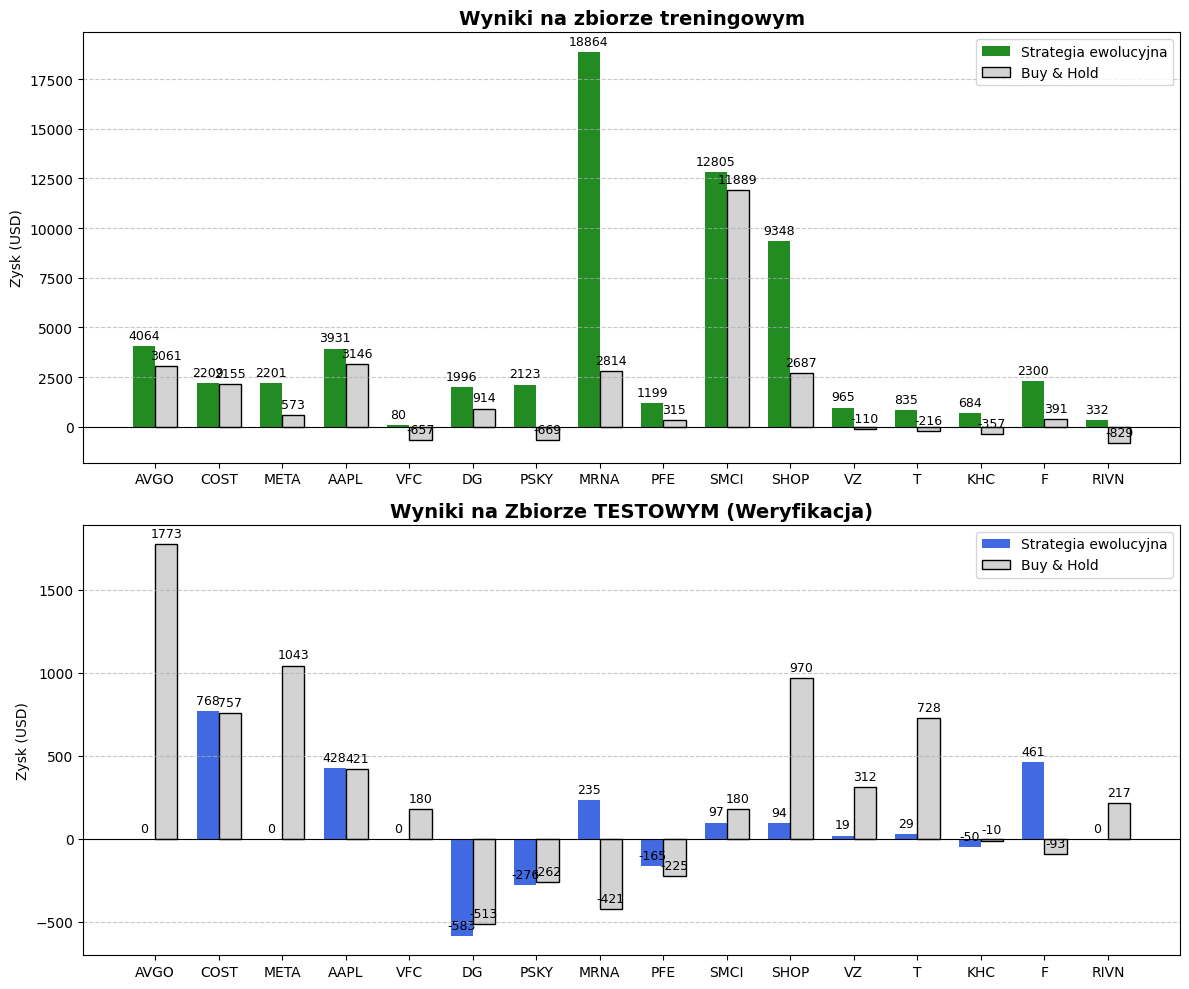

In [13]:
# zmniejszam max depth aby zapobiedz overfittingowi
plot_portfolio_comparison(compare_profits(tickers, population=1200, mutation_probability=0.22, max_depth=4, selection=tournament_selection, fitness_function=fast_backtest))

Jak widać gdy funkcją celu jest zwykła maksymalizacja zysku, algorytm bardzo overfituje na dane treningowe. Spróbujmy użyć innych funkcji straty niż sama maksymalizacja zysku aby algorytm był bardziej stabilny. 

Zamiast maksymalizować zysk spróbujmy zminimalizować wariancję wyników, do tego zastosujemy **Wskaźnik Sharpe'a**. Ocenia ona ile zysku generuje strategia w stosunku do ryzyka.

Wzór matematyczny:

$$Sharpe = \frac{E[R_p] - R_f}{\sigma_p}$$

Gdzie:
* $E[R_p]$ – oczekiwana stopa zwrotu portfela (średni zysk dzienny).
* $R_f$ – stopa wolna od ryzyka (dla uproszczenia przyjęto 0).
* $\sigma_p$ – odchylenie standardowe zwrotów portfela (miara zmienności/wariancji).

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: ['AVGO', 'COST', 'META', 'AAPL', 'VFC', 'DG', 'PSKY', 'MRNA', 'PFE', 'SMCI', 'SHOP', 'VZ', 'T', 'KHC', 'F', 'RIVN']

Znaleziono nowy najlepszy wynik: 0.9330853382771394, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 40}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


Znaleziono nowy najlepszy wynik: 1.0002800057327172, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0059356345084305, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 70}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.007492451755045, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0302135703054092, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 1.0325878448288768, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6928674643622275, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.7428722139457097, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.093484708518065, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.2874649353052041, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.3950870811692684, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 50}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.22090051257294838, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.44090299617546536, rule = {'type': 'if', 'condition': {'left': 90, 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7389777323047194, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>=', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 0.9317092344873925, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 90}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 1.0951104884343847, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 90}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA50'}

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6587900547280161, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.6655158012591159, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.6764037012905737, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.7234224790835885, rule = {'type': 'i

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.007527936721627, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.08941419810207, rule = {'type': 'if', 'condition': {'left': 90, 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8841474679421895, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.1075353313989456, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '==', 'right': 80}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 1.1171128350216422, rule = {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1403473277757539, rule = {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.9778492410750332, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.9892135222481271, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 1.1065402351600477, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1501126133525559, rule = {'type':

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0272735528324122, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 1.0783065915066712, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '<', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'RSI', 'op': '>', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1014971692695814, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': '

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7474642277738784, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.564015306609688, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 30}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.5754770880878582, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 20}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 0.993407255549242, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 20}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8184266989532988, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8097886899179778, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 1.1512142730096695, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


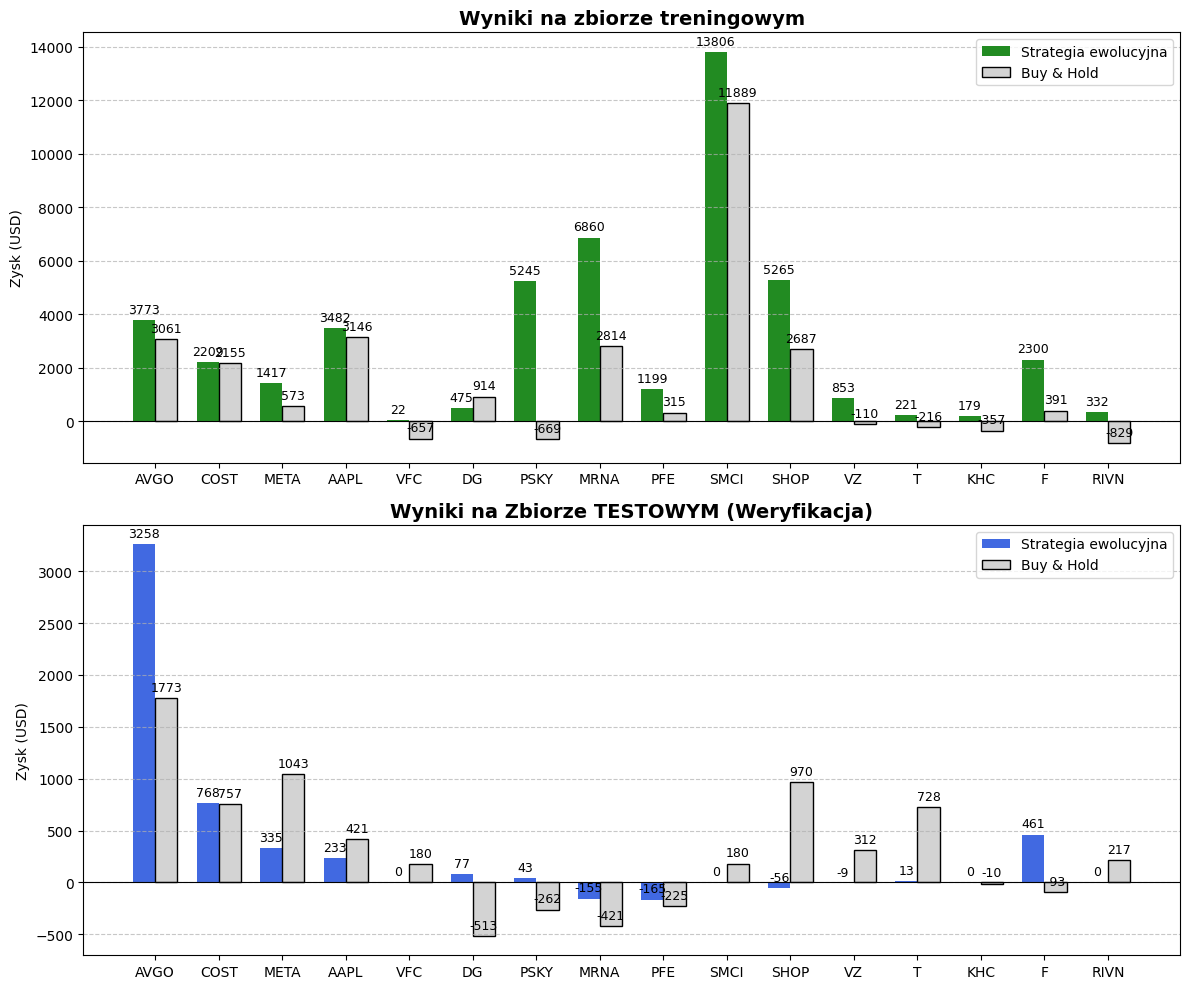

In [14]:
plot_portfolio_comparison(compare_profits(tickers, population=1250, mutation_probability=0.22, selection=tournament_selection, fitness_function=fitness_sharpe_ratio, max_depth=4))

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: ['AVGO', 'COST', 'META', 'AAPL', 'VFC', 'DG', 'PSKY', 'MRNA', 'PFE', 'SMCI', 'SHOP', 'VZ', 'T', 'KHC', 'F', 'RIVN']

Znaleziono nowy najlepszy wynik: 0.899328532874656, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


Znaleziono nowy najlepszy wynik: 1.0002800057327172, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.007492451755045, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6928674643622275, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.093484708518065, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '==', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.5920168718713729, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.7389777323047194, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6587900547280161, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.9431892100029559, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 1.007527936721627, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8841474679421895, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0850450648105459, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1075353313989456, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.9778492410750332, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.9892135222481271, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8119203840021658, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1014971692695814, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7474642277738784, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.4027897577023667, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.6068223921648852, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.6834045521701168, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


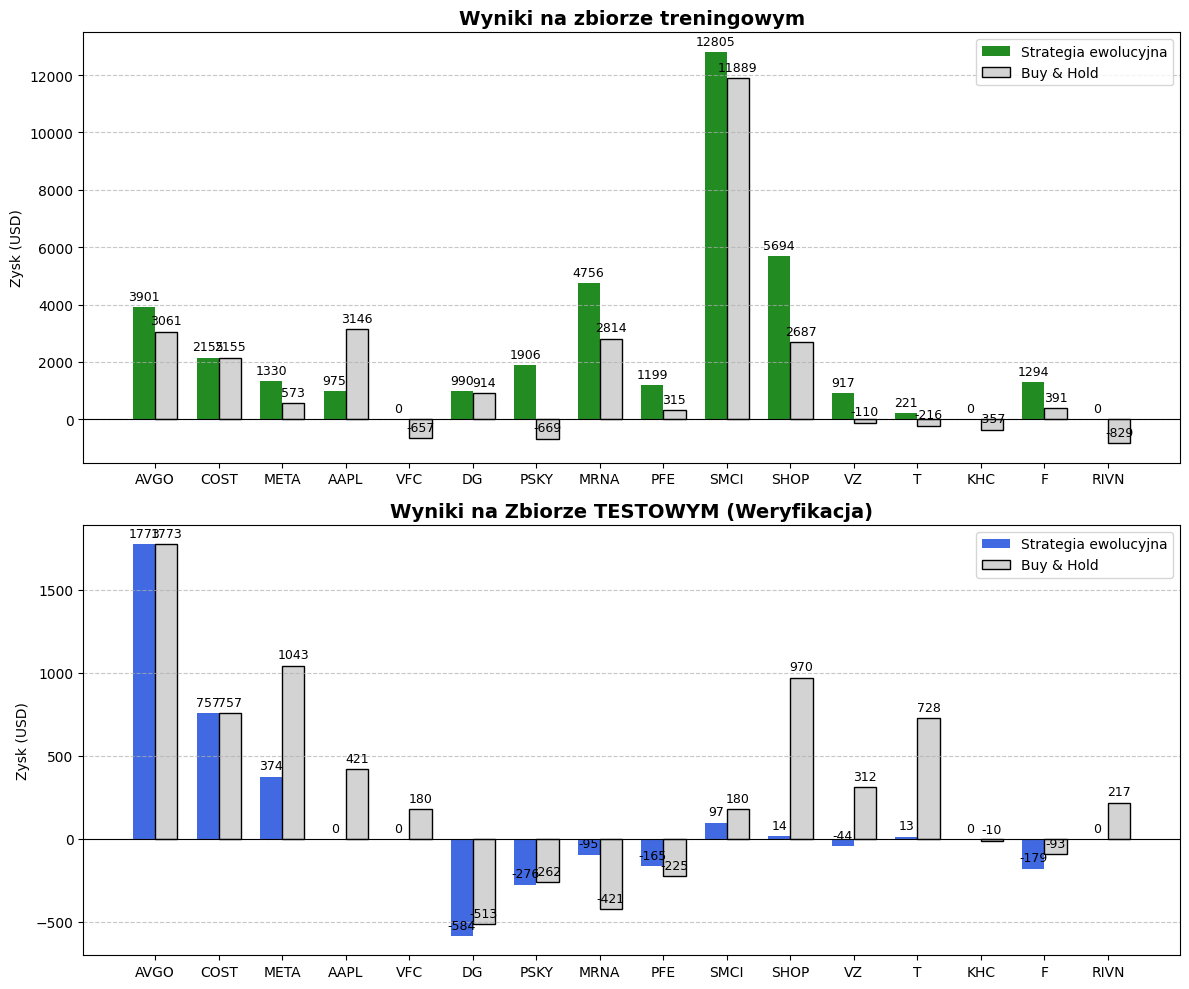

In [15]:
plot_portfolio_comparison(compare_profits(tickers, population=1250, mutation_probability=0.22, selection=tournament_selection, fitness_function=fitness_sharpe_ratio, max_depth=3))

Używając sharpe ratio udało się uzyskać wyniki z mniejszą warinacją, algorytm zarabia mniej ale też traci mniej od strategii buy and hold

Porównajmy jeszcze sharp ratio między naszą strategią a buy and hold

In [16]:
def calculate_sharpe_pure(equity_curve):
    returns = np.diff(equity_curve) / equity_curve[:-1]
    
    if len(returns) < 2 or np.std(returns) == 0:
        return 0.0

    sharpe = (np.mean(returns) / np.std(returns)) * np.sqrt(252)
    
    return sharpe

In [17]:
def compare_sharpe_ratios(tickers, population=500, chromosome_size=50, iterations=100, crossover_probability=0.8, mutation_probability=0.15, initial_cash=1000, max_depth=6, split_ratio=0.8, selection=roulette_selection, fitness_function=fast_backtest, crossover=one_point_crossover, mutation=random_mutation, seed=42):
    res = []
    print(f"Running sharpe ratio experiment on ticker: {tickers}\n")

    np.random.seed(seed)

    for ticker in tickers:
        data_full = get_fast_data(ticker, start="2018-01-01", end="2025-01-01")

        n_total = len(data_full['Close'])
        split_idx = int(n_total * split_ratio)

        data_train = {key: val[:split_idx] for key, val in data_full.items()}
        data_test =  {key: val[split_idx:] for key, val in data_full.items()}

        _, _, best_rule, _ = evolution(population, chromosome_size, crossover_probability, mutation_probability, iterations, population, data_train, grammar, initial_cash, max_depth, selection=selection, fitness_function=fitness_function, crossover=crossover, mutation=mutation)

        ai_curve_train = plot_backtest(best_rule, data_train, initial_cash)
        ai_curve_test = plot_backtest(best_rule, data_test, initial_cash)

        train_prices = data_train['Close']
        test_prices = data_test['Close']

        bh_curve_train = (train_prices / train_prices[0]) * initial_cash
        bh_curve_test = (test_prices / test_prices[0]) * initial_cash

        sharpe_train = calculate_sharpe_pure(ai_curve_train)
        bh_sharpe_train = calculate_sharpe_pure(bh_curve_train)
        
        sharpe_test = calculate_sharpe_pure(ai_curve_test)
        bh_sharpe_test = calculate_sharpe_pure(bh_curve_test)

        res.append({
                'ticker': ticker,
                'train': sharpe_train,
                'bh_train': bh_sharpe_train,
                'test': sharpe_test,
                'bh_test': bh_sharpe_test
            })
        
    return pd.DataFrame(res)

[*********************100%***********************]  1 of 1 completed

Running sharpe ratio experiment on ticker: ['AVGO', 'COST', 'META', 'AAPL', 'VFC', 'DG', 'PSKY', 'MRNA', 'PFE', 'SMCI', 'SHOP', 'VZ', 'T', 'KHC', 'F', 'RIVN']

Znaleziono nowy najlepszy wynik: 0.9800737901698968, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '==', 'right': 'Close'}, 'then': {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>=', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'Close', 'op': '==', 'right': 'Close'}}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 

Znaleziono nowy najlepszy wynik: 1.0002800057327172, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0992208962659535, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0325878448288768, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0381874613775, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'Close'}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'HOLD'}}}, 'else': {'type': 'action', 'value': 'HOLD'}}}
Znaleziono nowy najlepszy wynik: 1.1183284799154514, rule = {'type': 'if', 'condition': {'left': 30, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'els

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7203971494450097, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 20}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.7841843447418276, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '>', 'right': 'SMA50'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.3950870811692684, rule = {'type': 'if', 'condition': {'left': 50, 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.4443715731835534, rule = {'type': 'if', 'condition': {'left': 50, 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 50, 'op': '<', 'right': 40}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}}
Znaleziono nowy najlepszy wynik: 1.4732241121297032, rule = {'type': 'if', 'condition': {'left': 50, 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 50, 'op': '<', 'right': 40}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'i

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.23265410779671022, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '>', 'right': 10}, 'logic_op': 'AND', 'right': {'left': 20, 'op': '<', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.43551576633989325, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '>', 'right': 10}, 'logic_op': 'AND', 'right': {'left': 20, 'op': '<', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 60}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 0.4877127617509203, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '>', 'right': 10}, 'lo

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7389777323047194, rule = {'type': 'if', 'condition': {'left': {'left': 70, 'op': '>', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': {'left': {'left': 'RSI', 'op': '==', 'right': 'SMA10'}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '>=', 'right': 'Close'}}, 'logic_op': 'OR', 'right': {'left': 'SMA50', 'op': '<=', 'right': 'SMA10'}}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}}
Znaleziono nowy najlepszy wynik: 0.9620035305084377, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6587900547280161, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '==', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 0.7403556251566779, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 1.228432609117982, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0517047555288586, rule = {'type': 'if', 'condition': {'left': 80, 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 1.08941419810207, rule = {'type': 'if', 'condition': {'left': 90, 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8841474679421895, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.9977446597516433, rule = {'type': 'if', 'condition': {'left': {'left': 20, 'op': '<=', 'right': 'RSI'}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '<=', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0997161687423496, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1167176153965281, rule = {'type': 'if', 'condition': {'left': 50, 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.238770907707256, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': {'left': 'Close', 'op': '>=', 'right': 'SMA10'}, 'logic_op': 'OR', 'right': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '==', 'right': 'SMA5

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0357325183033614, rule = {'type': 'if', 'condition': {'left': 50, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 1.0871390859076058, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA50', 'op': '>', 'right': 'RSI'}, 'logic_op': 'AND', 'right': {'left': 'RSI', 'op': '<=', 'right': 'Close'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0875079822204696, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '==', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}}, 'else': {'type': 'action', 'va

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.1014971692695814, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '<=', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.2396735949474025, rule = {'type': 'if', 'condition': {'left': 30, 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 10, 'op': '<=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.255810826560951, rule = {'type': 'if', 'condition': {'left': 30, 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 10, 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'if', 'condition': {'left': 'RSI'

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7474642277738784, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.9660144701929121, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8647634574911767, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>', 'right': 60}, 'logic_op': 'AND', 'right': {'left': {'left': {'left': 'Close', 'op': '<=', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': 'SMA50', 'op': '>', 'right': 'SMA10'}}, 'logic_op': 'AND', 'right': {'left': 'SMA10', 'op': '<', 'right': 'RSI'}}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.9706493394851609, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>', 'right': 60}, 'logic_op': 'AND', 'right': {'left': {'left': {'left': 'Close', 'op': '<=', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': 'SMA50', 'op': '>', 'right': 'Close'}}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '<', 'right': 'RSI'}}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.998155958625649

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.729188460084326, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<=', 'right': 'SMA10'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.778942613187511, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.7860393996814162, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 40}, 'then': {'type': 'action', 'valu

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 30}, 'then': {'type': 'if', 'condition': {'left': 100, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 0.43239313943801855, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 10}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 0.7575294682061533, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.7654231055088635, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA50'}, 'then

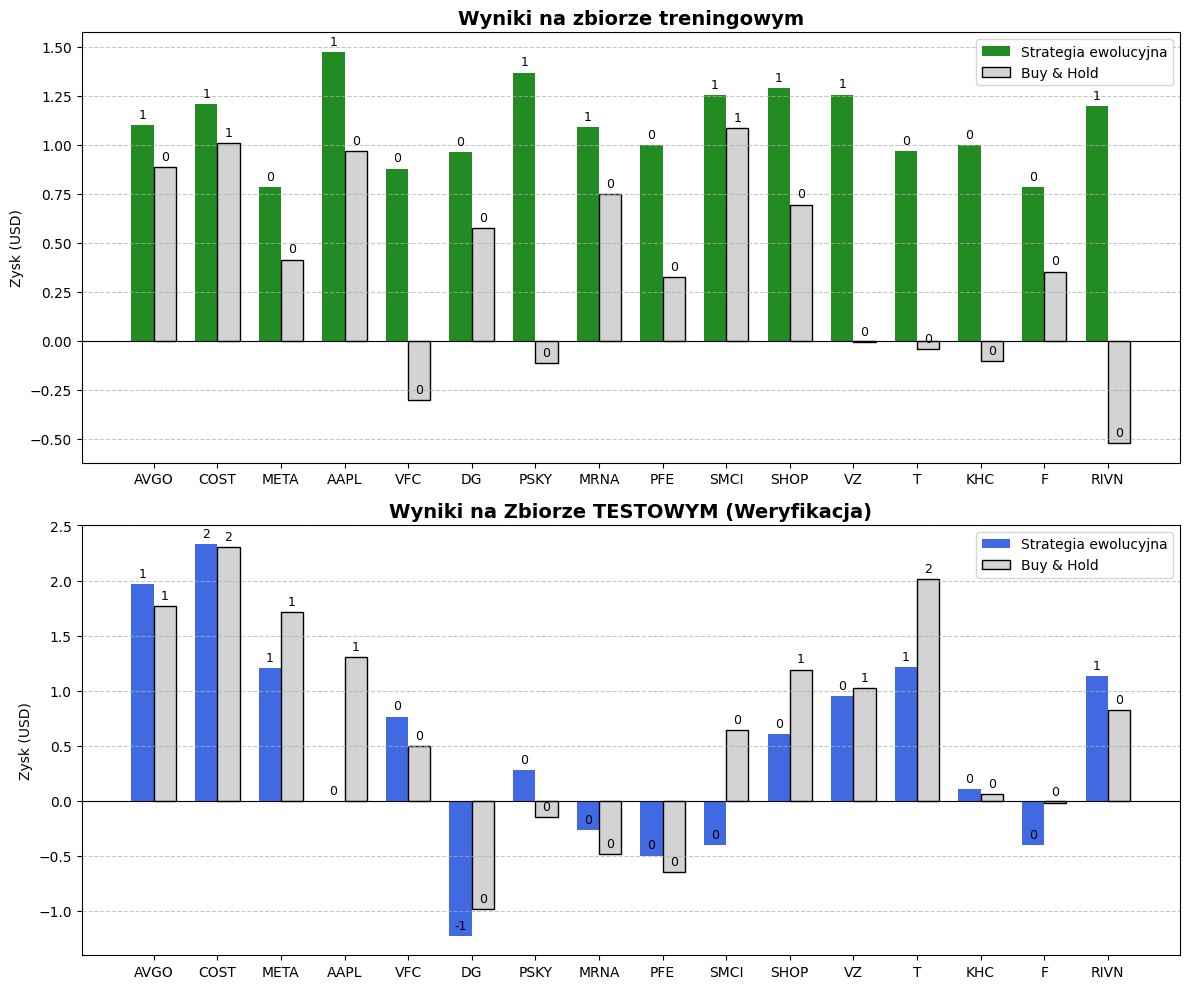

In [18]:
plot_portfolio_comparison(compare_sharpe_ratios(tickers, population=1200, selection=tournament_selection, fitness_function=fitness_sharpe_ratio))

[*********************100%***********************]  1 of 1 completed

Running sharpe ratio experiment on ticker: ['AVGO', 'COST', 'META', 'AAPL', 'VFC', 'DG', 'PSKY', 'MRNA', 'PFE', 'SMCI', 'SHOP', 'VZ', 'T', 'KHC', 'F', 'RIVN']

Znaleziono nowy najlepszy wynik: 0.9330853382771394, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 40}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


Znaleziono nowy najlepszy wynik: 1.0002800057327172, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0059356345084305, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 70}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.007492451755045, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.0302135703054092, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 1.0325878448288768, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6928674643622275, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.7428722139457097, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.093484708518065, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.2874649353052041, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.3950870811692684, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 50}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.22090051257294838, rule = {'type': 'if', 'condition': {'left': 20, 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.44090299617546536, rule = {'type': 'if', 'condition': {'left': 90, 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7389777323047194, rule = {'type': 'if', 'condition': {'left': {'left': 'RSI', 'op': '>=', 'right': 'Close'}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '>', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 0.9317092344873925, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 90}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 1.0951104884343847, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 90}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA50'}

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.6587900547280161, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.6655158012591159, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.6764037012905737, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.7234224790835885, rule = {'type': 'i

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.007527936721627, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.08941419810207, rule = {'type': 'if', 'condition': {'left': 90, 'op': '>', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8841474679421895, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.1075353313989456, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '==', 'right': 80}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 1.1171128350216422, rule = {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1403473277757539, rule = {'type': 'if', 'condition': {'left': 20, 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.9778492410750332, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 0.9892135222481271, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 1.1065402351600477, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'RSI'}, 'then': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1501126133525559, rule = {'type':

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 1.0272735528324122, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 1.0783065915066712, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '<', 'right': 'RSI'}, 'logic_op': 'OR', 'right': {'left': 'RSI', 'op': '>', 'right': 'SMA50'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 1.1014971692695814, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': '

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.7474642277738784, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.564015306609688, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>', 'right': 30}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 0.5754770880878582, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 20}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 0.993407255549242, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 20}, 'then': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8184266989532988, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.8097886899179778, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 1.1512142730096695, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


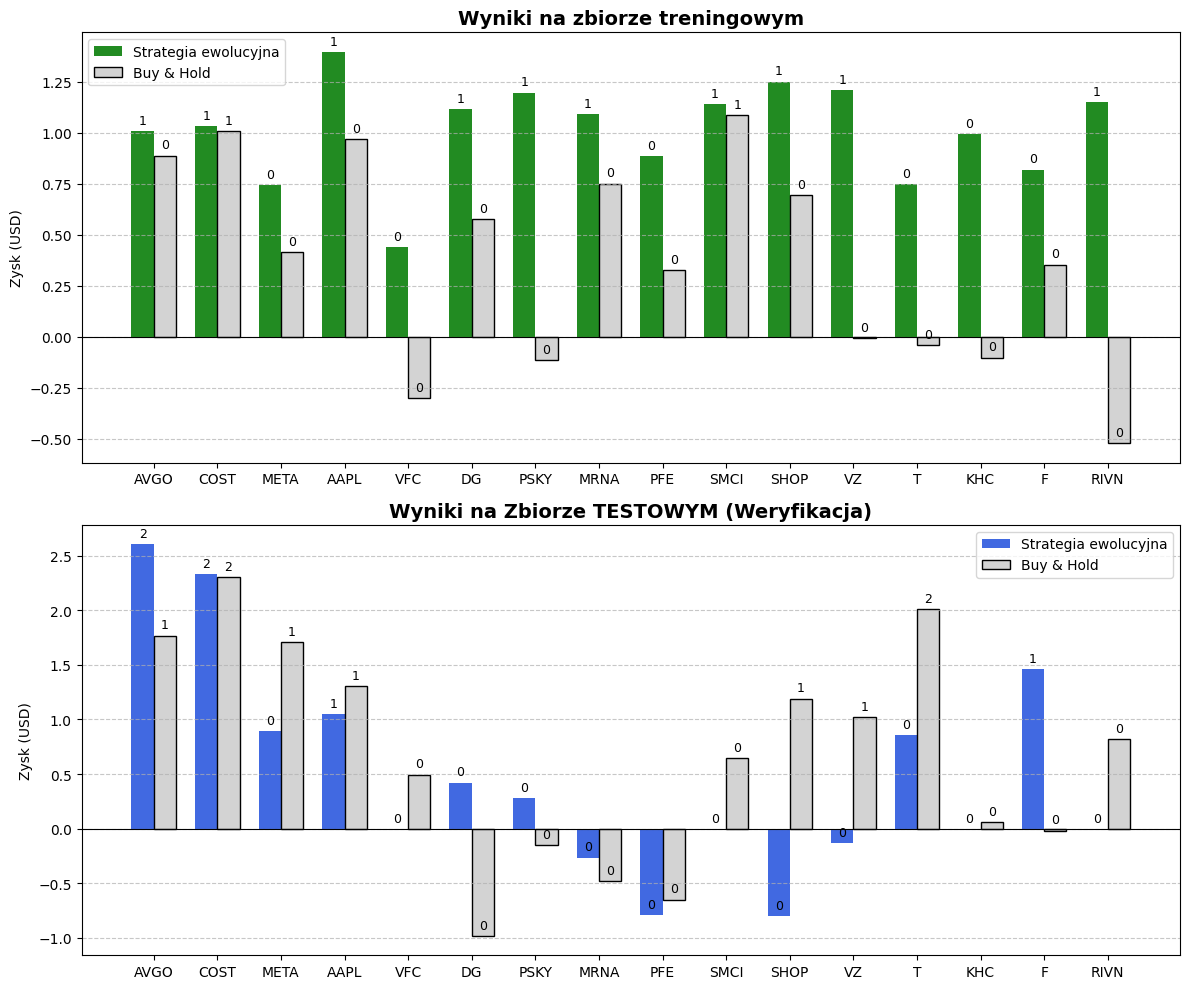

In [19]:
plot_portfolio_comparison(compare_sharpe_ratios(tickers, population=1250, mutation_probability=0.22, selection=tournament_selection, fitness_function=fitness_sharpe_ratio, max_depth=4))

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: TSLA

Running evolution
Znaleziono nowy najlepszy wynik: 25296.804270823897, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'logic_op': 'OR', 'right': {'left': 50, 'op': '>=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


Best rule found:
{'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'logic_op': 'OR', 'right': {'left': 50, 'op': '>=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}



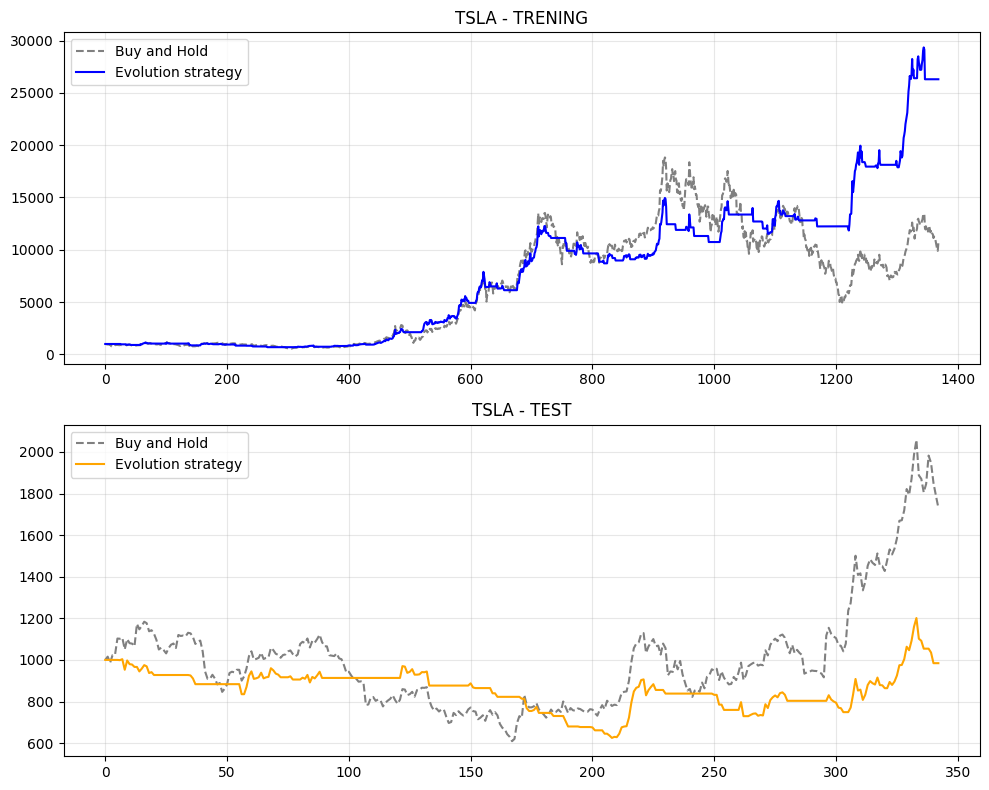

Algorytm na danych treningowych zarobił: 25296.804270823897
Buy and hold na danych treningowych zarobiło: 9621.19208384042
Algorytm na danych testowych zarobił: -15.69177334074459
Buy and hold na danych testowych zarobiło: 731.8066474113259


{'type': 'if',
 'condition': {'left': {'left': 'Close', 'op': '<', 'right': 'SMA10'},
  'logic_op': 'OR',
  'right': {'left': 50, 'op': '>=', 'right': 'RSI'}},
 'then': {'type': 'action', 'value': 'SELL'},
 'else': {'type': 'action', 'value': 'BUY'}}

In [20]:
compare_profit_with_plot('TSLA', max_depth=5, selection=tournament_selection)

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: TSLA

Running evolution
Znaleziono nowy najlepszy wynik: 1.492526793675076, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


Znaleziono nowy najlepszy wynik: 1.552456723071566, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 30, 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Best rule found:
{'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 30, 'op': '>', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}



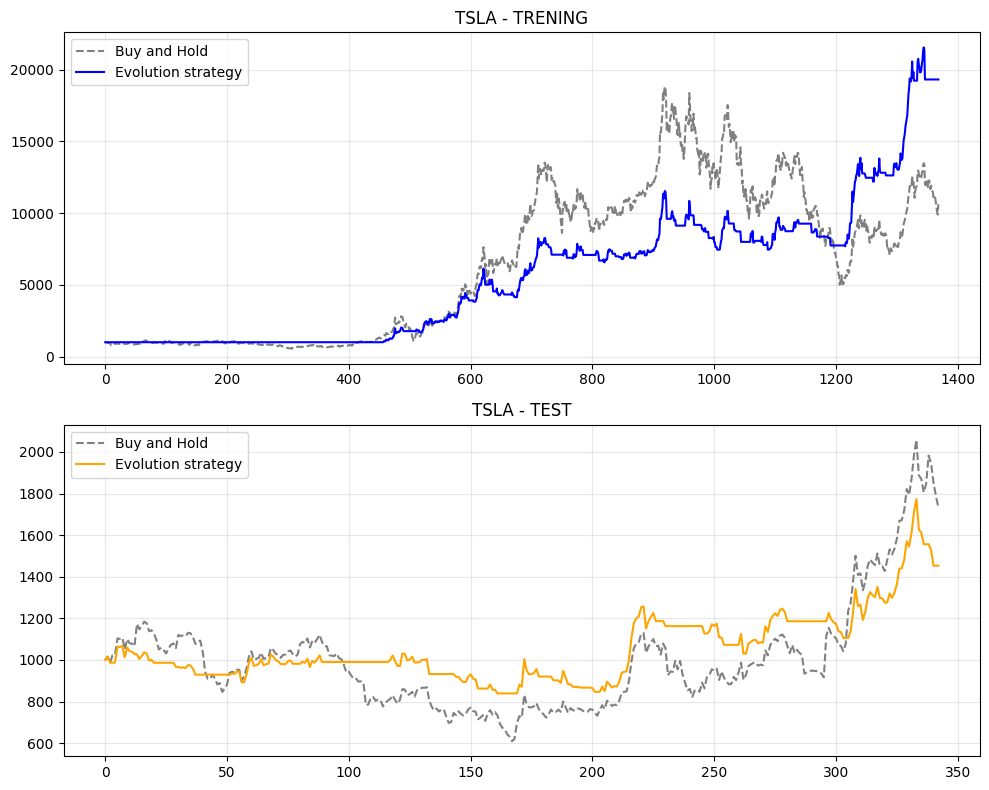

Algorytm na danych treningowych zarobił: 18313.88885433085
Buy and hold na danych treningowych zarobiło: 9621.19208384042
Algorytm na danych testowych zarobił: 453.1791417051006
Buy and hold na danych testowych zarobiło: 731.8066474113259


{'type': 'if',
 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'},
 'then': {'type': 'action', 'value': 'SELL'},
 'else': {'type': 'if',
  'condition': {'left': 30, 'op': '>', 'right': 'Close'},
  'then': {'type': 'action', 'value': 'SELL'},
  'else': {'type': 'action', 'value': 'BUY'}}}

In [21]:
compare_profit_with_plot('TSLA', max_depth=5, fitness_function=fitness_sharpe_ratio, selection=tournament_selection)